In [1]:
import rioxarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es

# Sentinel-2 Bands	Central Wavelength (µm)	Resolution (m)
# Band 1 - Coastal aerosol	0.443	60
# Band 2 - Blue	0.490	10
# Band 3 - Green	0.560	10
# Band 4 - Red	0.665	10
# Band 5 - Vegetation Red Edge	0.705	20
# Band 6 - Vegetation Red Edge	0.740	20
# Band 7 - Vegetation Red Edge	0.783	20
# Band 8 - NIR	0.842	10
# Band 8A - Vegetation Red Edge	0.865	20
# Band 9 - Water vapour	0.945	60
# Band 10 - SWIR - Cirrus	1.375	60
# Band 11 - SWIR	1.610	20
# Band 12 - SWIR	2.190	20

# Connect to drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !ls /content/drive/MyDrive/conida/Tarea_01
# data_path="/content/drive/MyDrive/conida/Tarea_01"

In [2]:
def display_multiple_img(images, rows = 1, cols=1, size=20,cmap='gist_earth'):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(size, size) )
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title].variable.data[0],cmap = cmap)
        ax.ravel()[ind].set_title(title)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

In [5]:
!ls data/
data_path = "data"

B04_t1.tif  B08_t1.tif	T19KBA_20210310T145729_TCI_10m.jp2
B04_t2.tif  B08_t2.tif	T19KBA_20210320T145729_TCI_10m.jp2


# Calculate NDVI 10/03/2021 - B04 and B08

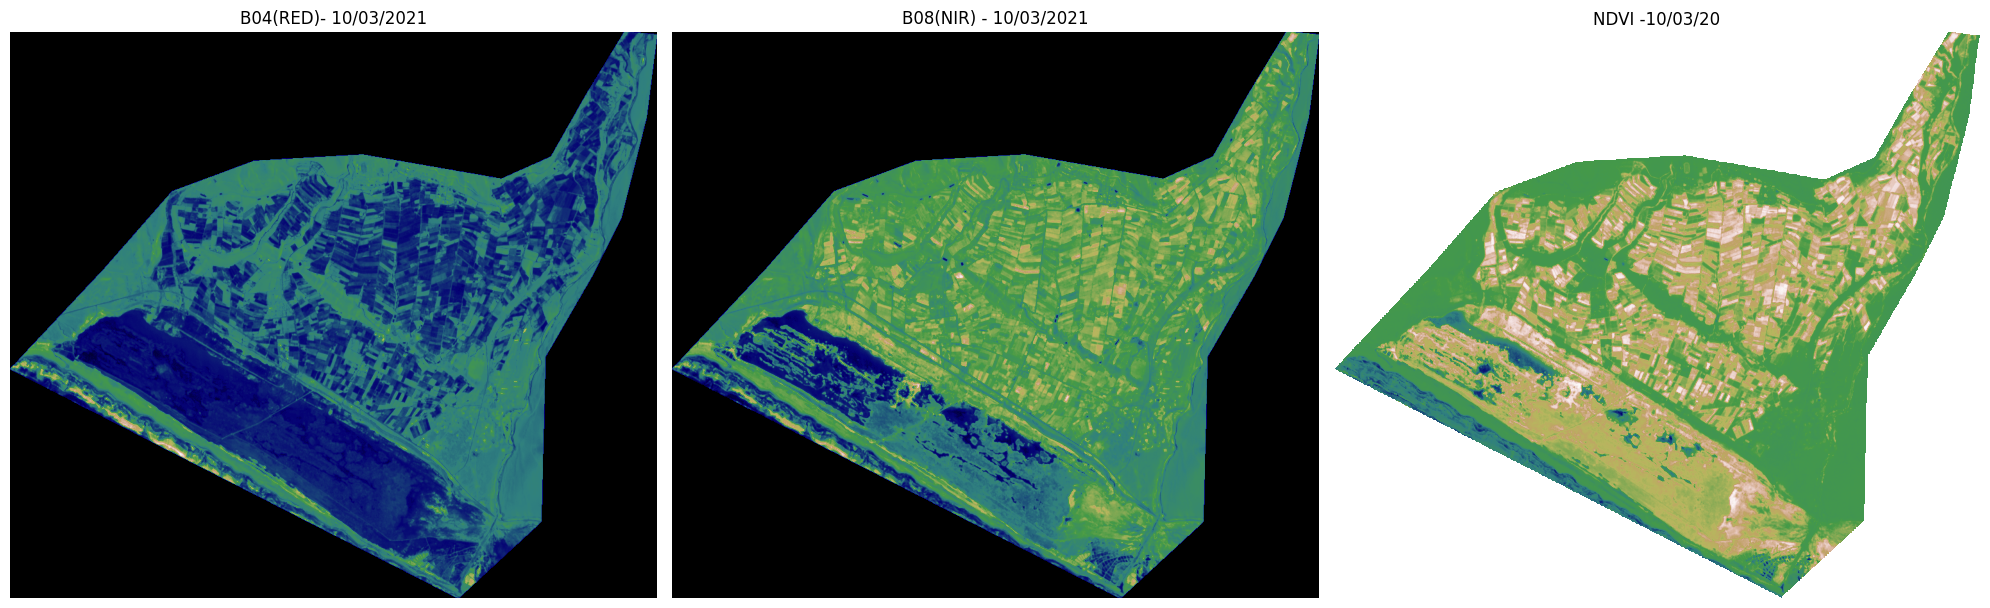

In [6]:
red_t1 = xr.open_rasterio(data_path + "/B04_t1.tif")
nir_t1 = xr.open_rasterio(data_path + "/B08_t1.tif")
ndvi_t1 = (nir_t1.astype(float) - red_t1.astype(float))/(nir_t1 + red_t1)
images = {"B04(RED)- 10/03/2021":red_t1,
          "B08(NIR) - 10/03/2021":nir_t1,
          "NDVI -10/03/20": ndvi_t1}
display_multiple_img(images, 1,3,20)

# Calculate NDVI 20/03/2021 - B04 and B08
---



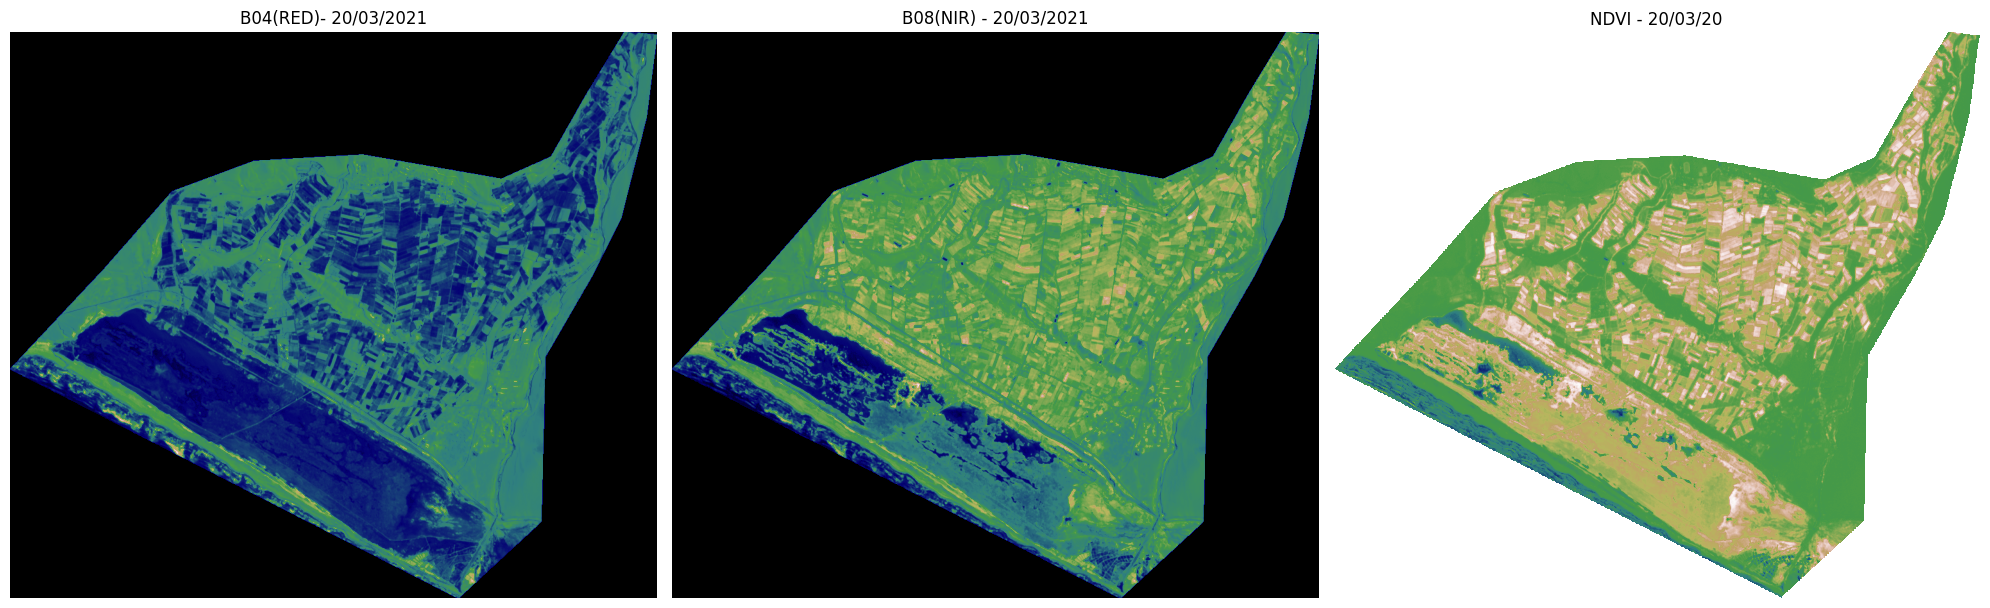

In [7]:
red_t2 = xr.open_rasterio(data_path + "/B04_t2.tif")
nir_t2 = xr.open_rasterio(data_path + "/B08_t2.tif")
ndvi_t2 = (nir_t2.astype(float) - red_t2.astype(float))/(nir_t2 + red_t2)
images = {"B04(RED)- 20/03/2021":red_t2,
                   "B08(NIR) - 20/03/2021":nir_t2,
                   "NDVI - 20/03/20": ndvi_t2}
display_multiple_img(images, 1,3,20)

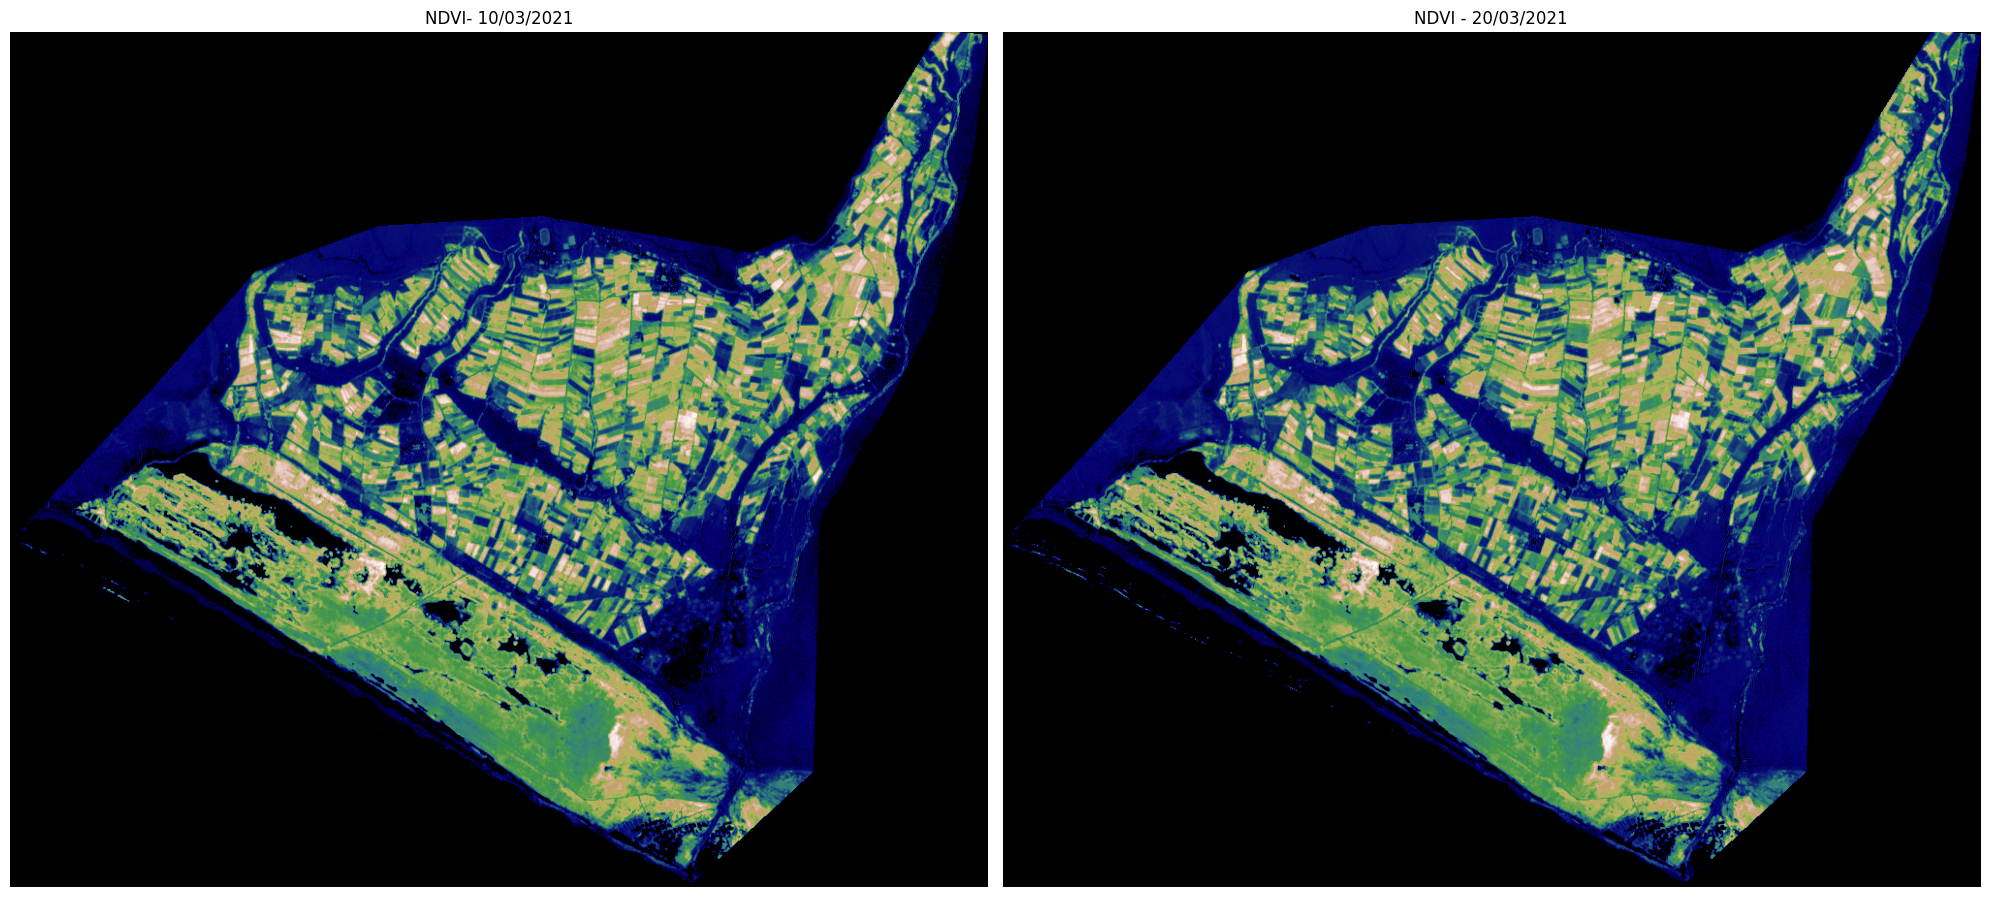

In [8]:
# filter only values for NDVI
ndvi_t1_fixed = ndvi_t1.where(ndvi_t1 > 0, 0)
ndvi_t2_fixed = ndvi_t2.where(ndvi_t2 > 0 , 0)
images = {"NDVI- 10/03/2021":ndvi_t1_fixed,
          "NDVI - 20/03/2021":ndvi_t2_fixed}
display_multiple_img(images, 1,2,20)

In [9]:
ndvi_t1_fixed.rio.to_raster(data_path + "/ndvi_t1.tif")
ndvi_t2_fixed.rio.to_raster(data_path + "/ndvi_t2.tif")


# Analysing NDVI values - Harvest

In [37]:
ndvi_diff = ndvi_t2_fixed.astype(float) - ndvi_t1_fixed.astype(float)
# ndvi_diff.plot()
# ndvi_diff.rio.to_raster(data_path + "/ndvi_diff_t2-t1.tif")


In [38]:
cosecha =ndvi_diff.where(ndvi_diff < 0, 0)
# negative_ones = np.ones(ndvi_diff.shape)*-1
# Make positive
cosecha = cosecha*(-1)
cosecha.rio.to_raster(data_path + "/harvest.tif")

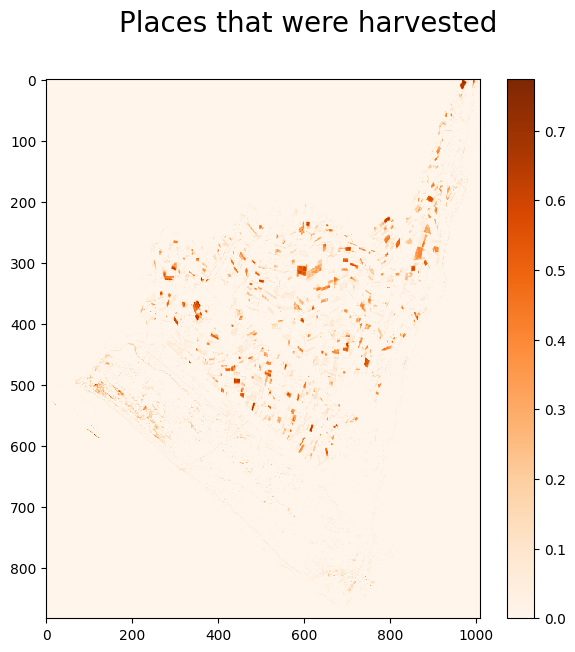

In [45]:
plt.figure(figsize = (7,7))
plt.imshow(cosecha.variable.data[0], cmap="Oranges", interpolation='nearest', aspect='auto')
plt.suptitle('Places that were harvested', fontsize=20)
plt.colorbar()
plt.show()


In [19]:
reverdecimiento =ndvi_diff.where(ndvi_diff > 0, 0)
# reverdecimiento.plot()
reverdecimiento.rio.to_raster(data_path + "/reverdecimiento.tif")


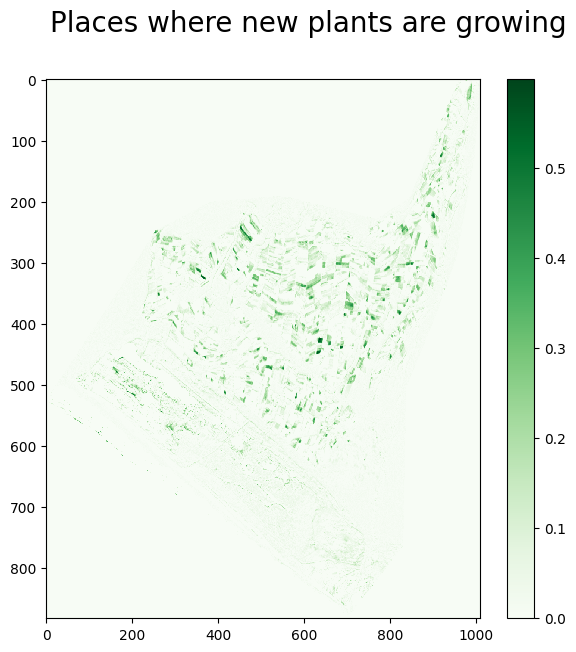

In [46]:
plt.figure(figsize = (7,7))
plt.imshow(reverdecimiento.variable.data[0], cmap="Greens", interpolation='nearest', aspect='auto')
plt.suptitle('Places where new plants are growing', fontsize=20)
plt.colorbar()
plt.show()

# Clustering

In [21]:
import rasterio as rio
from rasterio.plot import show
from sklearn import cluster
import matplotlib.pyplot as plt
import numpy as np


In [22]:
# Open the image 
cosecha_raster = rio.open(data_path + "/harvest.tif")

# Read, enhance and show the image
elhas_arr = cosecha_raster.read() # read the opened image

# create an empty array with same dimension and data type
imgxyb = np.empty((cosecha_raster.height, cosecha_raster.width, cosecha_raster.count), cosecha_raster.meta['dtype'])
# loop through the raster's bands to fill the empty array
for band in range(imgxyb.shape[2]):
    imgxyb[:,:,band] = cosecha_raster.read(band+1)

# # convert to 1d array
print(imgxyb.shape)
img1d=imgxyb[:,:,:2].reshape((imgxyb.shape[0]*imgxyb.shape[1],imgxyb.shape[2]))
print(img1d.shape)


(883, 1009, 2)
(890947, 2)


In [23]:
cl = cluster.KMeans(n_clusters=4) # create an object of the classifier
param = cl.fit(img1d) # train it
img_cl = cl.labels_ # get the labels of the classes

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
print(imgxyb.shape)
img_cl = img_cl.reshape(imgxyb[:,:,1].shape) # reshape labels to a 3d array (one band only)
print(img_cl.shape)


(883, 1009, 2)
(883, 1009)


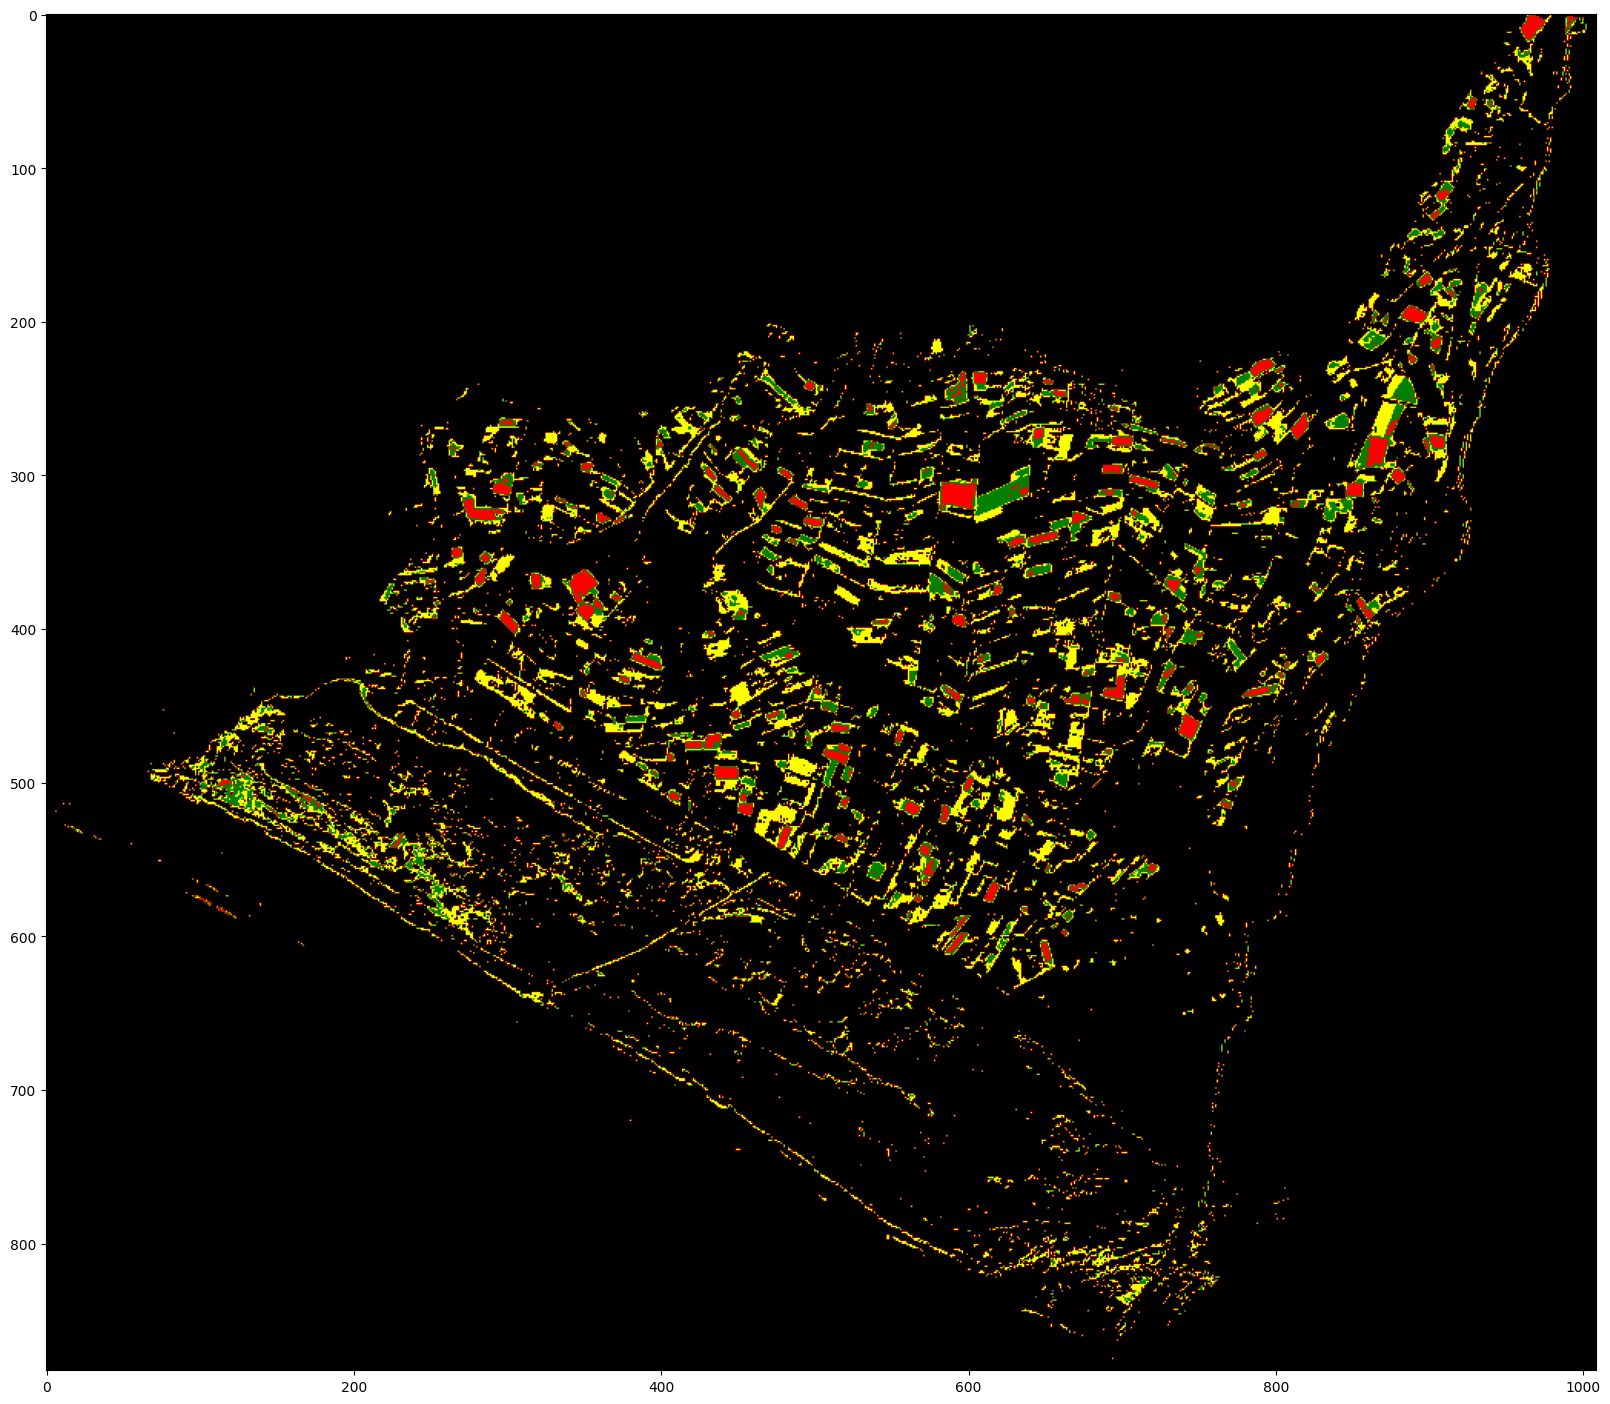

In [25]:
import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red","green","yellow"])
# Show the resulting array and save it as jpg image
plt.figure(figsize=[20,20])
plt.imshow(img_cl, cmap=cmap)
# plt.axis('off')
plt.savefig(data_path + "/tacna_clustered.jpg", bbox_inches='tight')
plt.show()



